In [1]:
import os

from matplotlib import pyplot as plt
from skimage.morphology import binary_dilation

from src.fish import find_fish_props
from src.models import InputImage
from src.utils import normalize_0_255
from src.well import find_well_props


In [2]:
def plot_images(images, cols: int = None, count: int = None, fig: (int, int) = (16, 16), ticks=False, cmap='binary',
                title=None, hist=False, nums=False):
    if count is not None:
        images = images[0:count]

    l = len(images)

    if l == 0:
        return

    if cols is None:
        cols = 4

    rows = int(l / cols)
    if cols > l > 1: cols = l
    if l % cols != 0 or rows == 0:
        rows += 1

    fig, ax = plt.subplots(rows, cols, figsize=fig)
    ax = ax.ravel()

    for i, img in enumerate(images):
        if i >= l: return

        if nums: ax[i].set_title(f'#{i}')

        if not hist:
            ax[i].imshow(img, cmap)
            if not ticks:  # turn off ticks
                ax[i].get_xaxis().set_visible(False)
                ax[i].get_yaxis().set_visible(False)
        else:
            ax[i].hist(img.ravel(), bins=256)
    fig.suptitle(title, fontsize=56)
    plt.tight_layout()


def plot_fishes(fishes, cols: int = None, count: int = None, fig: (int, int) = (16, 16), ticks=False, cmap='binary',
                title=None, nums=False):
    images = list(map(lambda x: x.processed, fishes))  # Change this!
    plot_images(images, cols, count, fig, ticks, cmap, title, nums)

In [3]:
os.chdir('C:\\Users\\gimes\\source\\repos\\zebra_fishy\\src\\images\\in')
fish_names = os.listdir()
os.chdir('C:\\Users\\gimes\\source\\repos\\zebra_fishy\\src')

fishes = []
fishes_ = []
for name in fish_names[::]:
    print(name)
    fishes.append(InputImage(name))
for i, fish in enumerate(fishes):
    print(f'Fish #{i}')
    fish.processed = normalize_0_255(fish.processed)
    fish = find_well_props(fish)
    fish = find_fish_props(fish)
    if (fish.fish_props.has_fish and fish.fish_props.has_fish):
        fishes_.append(fish)

zf1.JPG
Reading in file from:
C:\Users\gimes\source\repos\zebra_fishy\src\images\in\zf1.JPG
zf10.jpg
Reading in file from:
C:\Users\gimes\source\repos\zebra_fishy\src\images\in\zf10.jpg
zf11.jpg
Reading in file from:
C:\Users\gimes\source\repos\zebra_fishy\src\images\in\zf11.jpg
zf12.jpg
Reading in file from:
C:\Users\gimes\source\repos\zebra_fishy\src\images\in\zf12.jpg
zf13.jpg
Reading in file from:
C:\Users\gimes\source\repos\zebra_fishy\src\images\in\zf13.jpg
zf14.jpg
Reading in file from:
C:\Users\gimes\source\repos\zebra_fishy\src\images\in\zf14.jpg
zf15.jpg
Reading in file from:
C:\Users\gimes\source\repos\zebra_fishy\src\images\in\zf15.jpg
zf16.jpg
Reading in file from:
C:\Users\gimes\source\repos\zebra_fishy\src\images\in\zf16.jpg
zf17.jpg
Reading in file from:
C:\Users\gimes\source\repos\zebra_fishy\src\images\in\zf17.jpg
zf18.jpg
Reading in file from:
C:\Users\gimes\source\repos\zebra_fishy\src\images\in\zf18.jpg
zf19.jpg
Reading in file from:
C:\Users\gimes\source\repos\zeb

C:\Users\gimes\.miniconda\lib\site-packages\scipy\signal\signaltools.py:1611: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)


# Applying yen-threshold
_____________________________________________________________
# Removing meniscus
_____________________________________________________________
# Keeping only the possible fish
_____________________________________________________________
# Convex hull for mask
_____________________________________________________________
# Bounding box of fish
_____________________________________________________________
# Refining mask
_____________________________________________________________
# Convex hull for mask
_____________________________________________________________
# Bounding box from OG
_____________________________________________________________
IS FISH!
# Getting head of fish
_____________________________________________________________
# Searching for eye regions
_____________________________________________________________
# Removing objects close to the middle of the embryo
_____________________________________________________________
# Found 2 eyes!
___

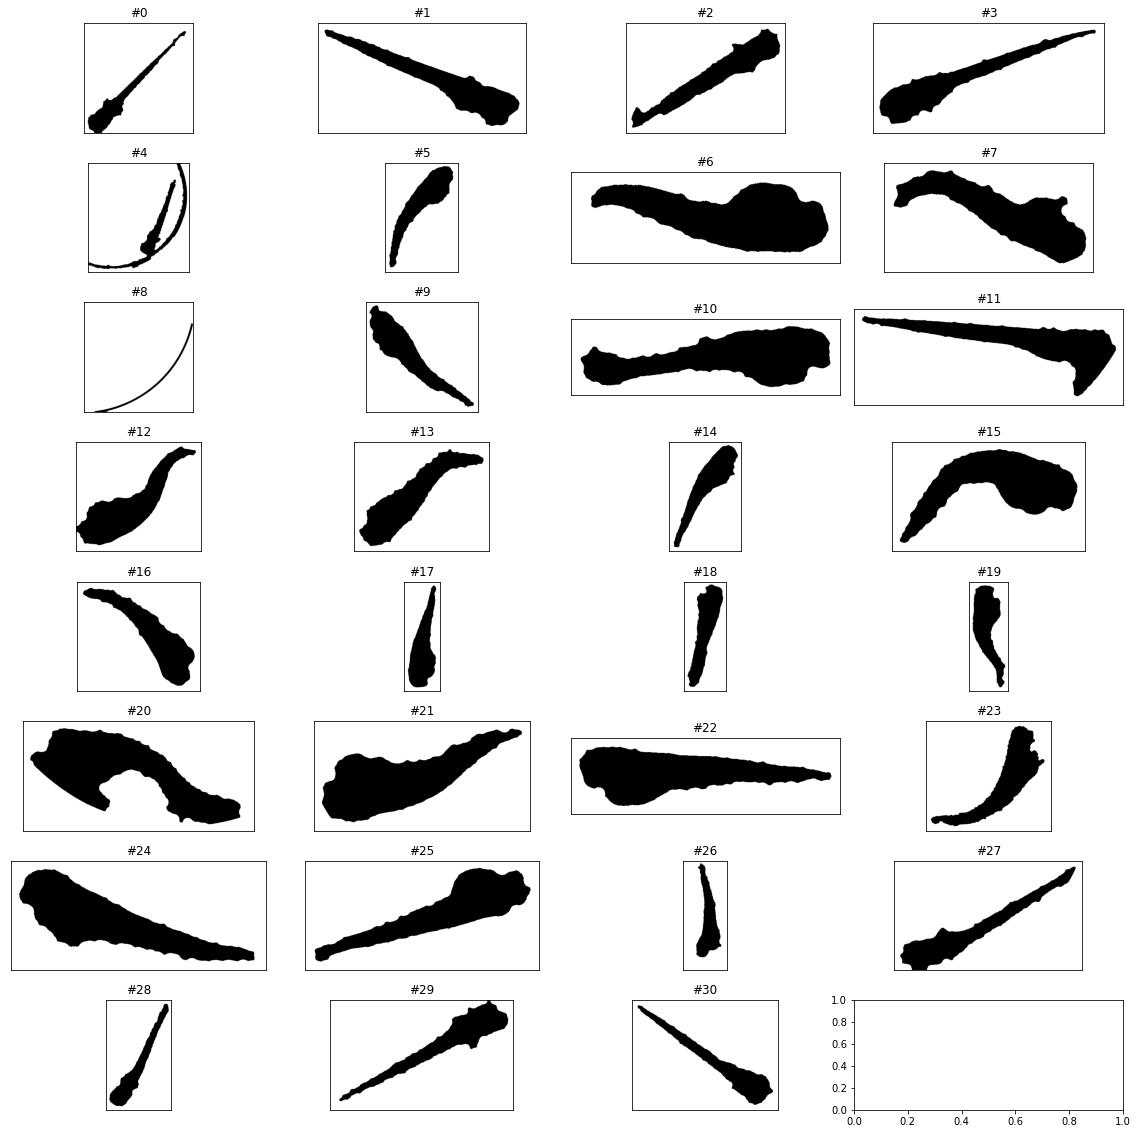

In [4]:
plot_images(list(map(lambda x: (x.fish_props.mask.cropped), fishes)), nums=True)

#0
#1
#2
#3
#4
#5
#6
#7
#8
#9
#10
#11
#12
#13
#14
#15
#16
#17
#18
#19
#20
#21
#22
#23
#24
#25
#26
#27
#28
#29


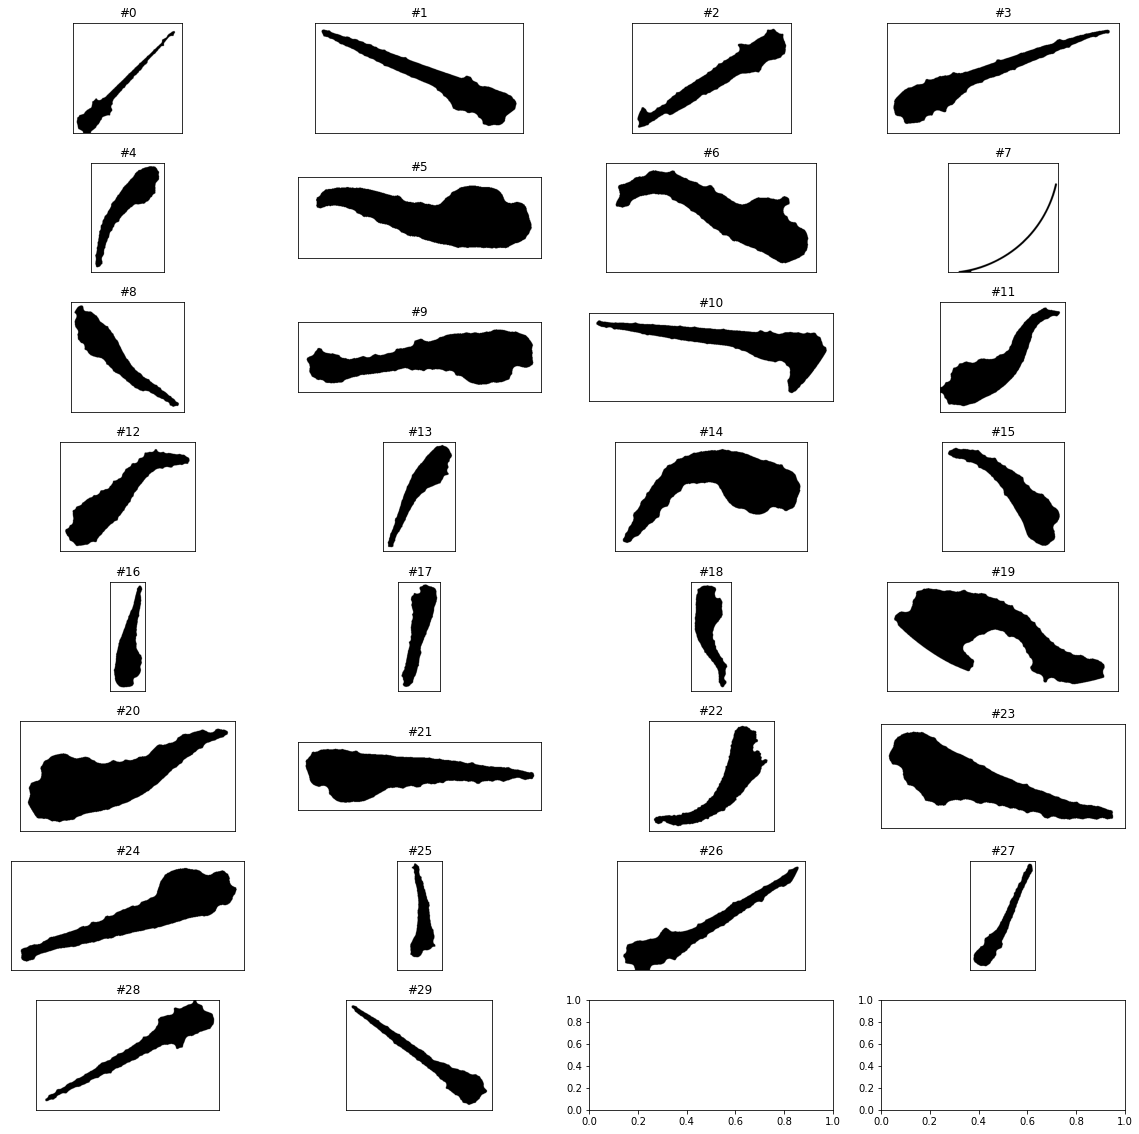

In [5]:
masks = []

for i, fish in enumerate(fishes_):
    print(f'#{i}')
    if fish.fish_props.has_fish: masks.append(fish.fish_props.mask.cropped)
plot_images(masks, nums=True)

#0
#1
#2
#3
#4
#5
#6
#7
#8
#9
#10
#11
#12
#13
#14
#15
#16
#17
#18
#19
#20
#21
#22
#23
#24
#25
#26
#27
#28
#29


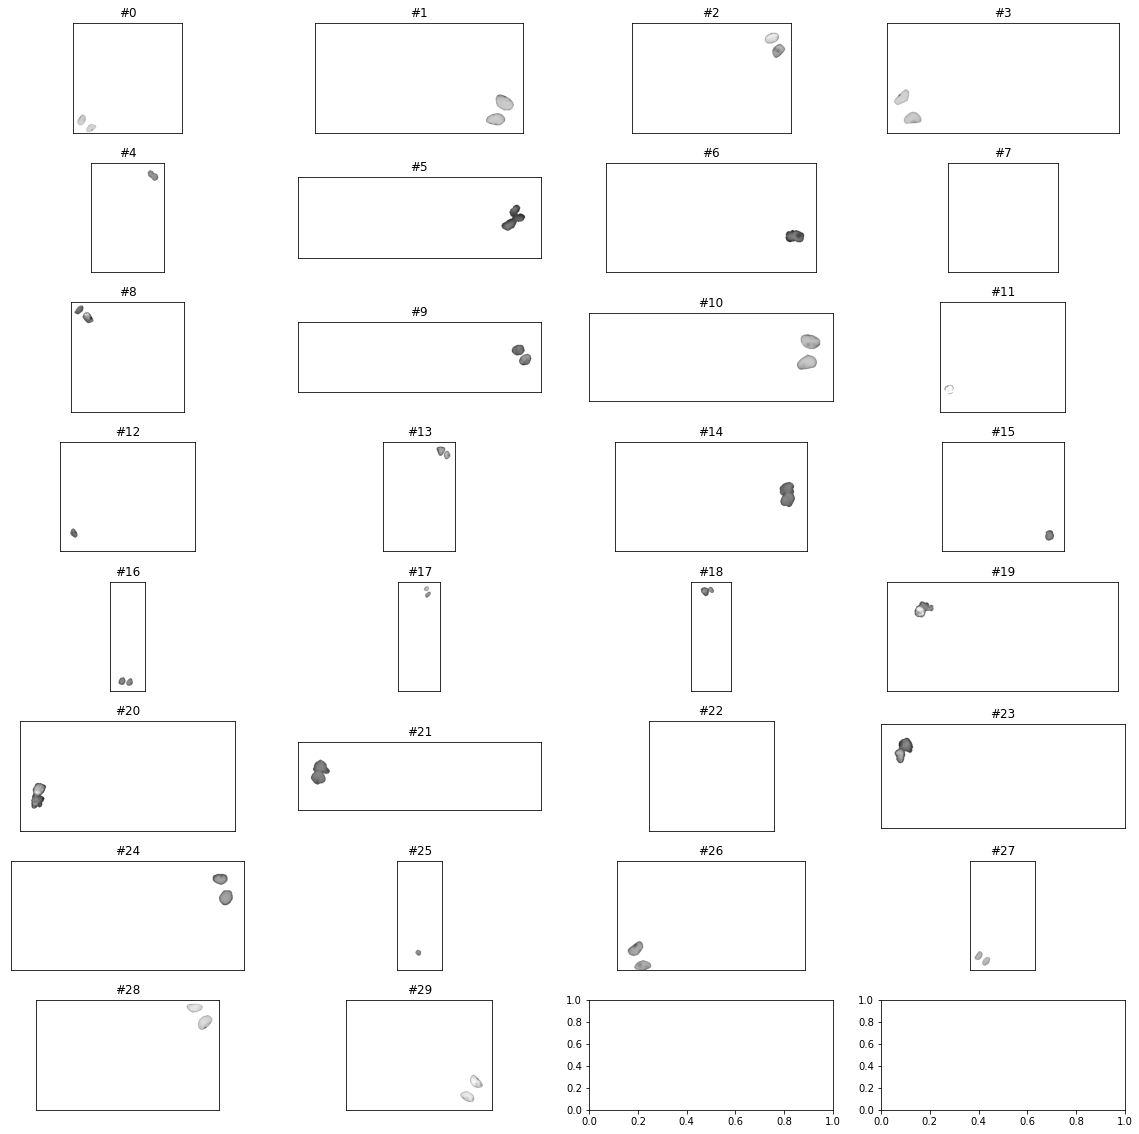

In [6]:
eyes = []

from src.utils import show_img

for i, fish in enumerate(fishes_):
    print(f'#{i}')
    eyes.append(fish.fish_props.eyes * fish.fish_props.cropped_og)

plot_images(eyes, nums=True)

#0
#1
#2
#3
#4
#5
#6
#7
#8
#9
#10
#11
#12
#13
#14
#15
#16
#17
#18
#19
#20
#21
#22
#23
#24
#25
#26
#27
#28
#29


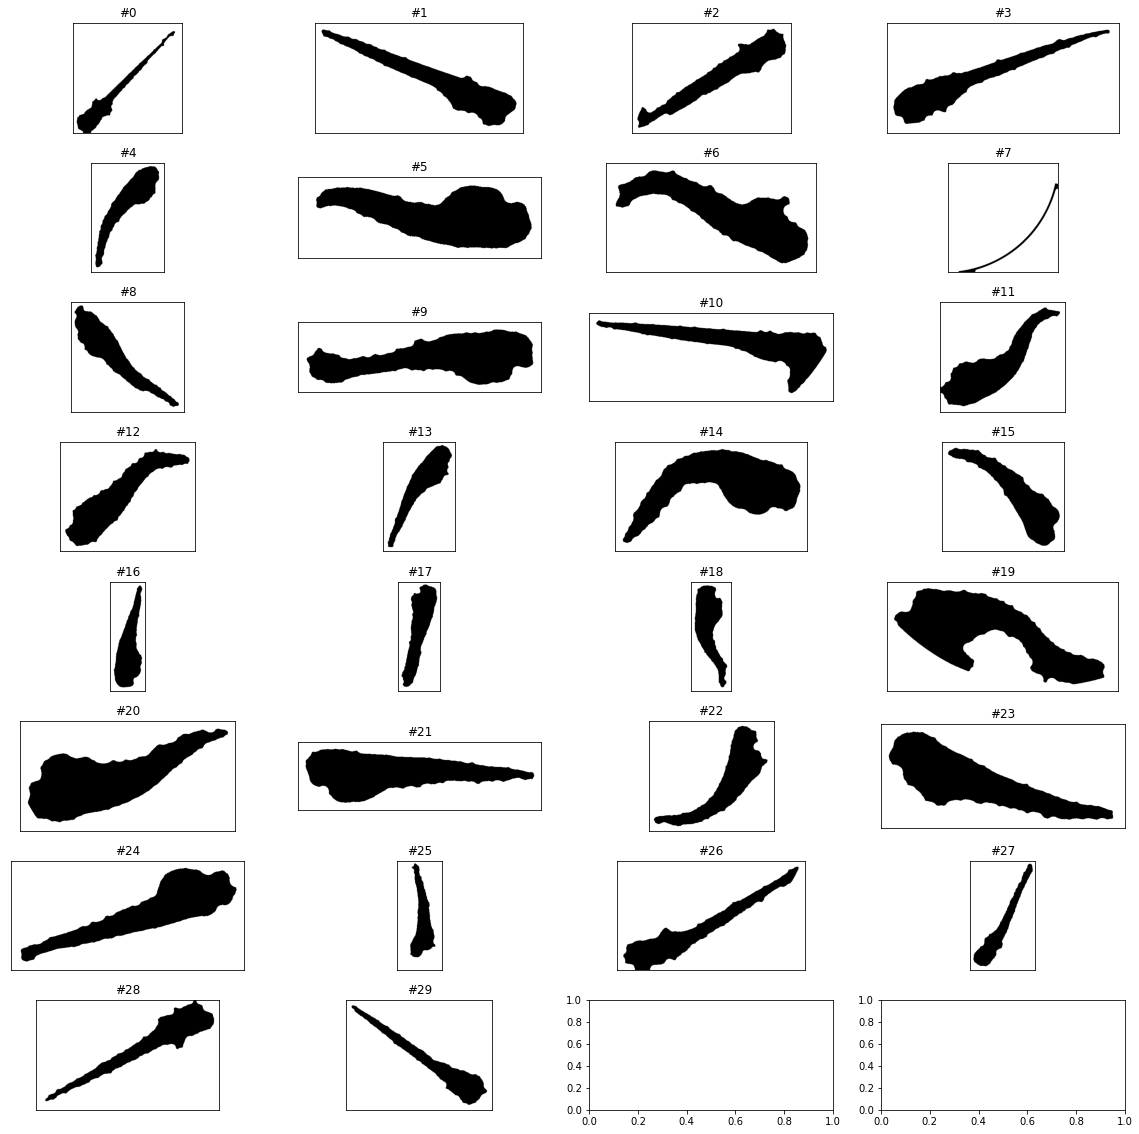

In [7]:

from skimage.morphology import disk, binary_closing

maks = []
_proc = []

for i, fish in enumerate(fishes_):
    print(f"#{i}")
    og = fish.fish_props.cropped_og if not fishes[i].fish_props.rotated else fish.fish_props.cropped_og.transpose()
    maks.append(binary_closing(fish.fish_props.mask.cropped.astype(float) + eyes[i].astype(float), disk(15)))
plot_images(maks, nums=True)

In [8]:
from skimage.measure import regionprops
from skimage.measure import label

all_ = []
ori = []

for i, t in enumerate(masks):
    print(f'#{i}')
    o = regionprops(label(masks[i]))[0].orientation
    ori.append(o)
    all_.append(t)
    print(f'orient mask: {o}')

#0
orient mask: -0.7594893678949676
#1
orient mask: 1.1532709016865892
#2
orient mask: -1.0365253866789699
#3
orient mask: -1.1877260162693046
#4
orient mask: -0.6135780081288146
#5
orient mask: 1.4473357151857829
#6
orient mask: 1.2186528074972107
#7
orient mask: -0.8283363775964593
#8
orient mask: 0.7935899006498148
#9
orient mask: -1.4984394522090538
#10
orient mask: 1.395385388849181
#11
orient mask: -0.8715425138254053
#12
orient mask: -0.8535865097322269
#13
orient mask: -0.5667211018854296
#14
orient mask: -1.4438587109950618
#15
orient mask: 0.7879086784856649
#16
orient mask: -0.13552543588664606
#17
orient mask: -0.2043816274523749
#18
orient mask: 0.1495854804790375
#19
orient mask: 1.2629131729967966
#20
orient mask: -1.2596657058767469
#21
orient mask: -1.5697645997118117
#22
orient mask: -0.7123275146918706
#23
orient mask: 1.2609395084331299
#24
orient mask: -1.223639582343128
#25
orient mask: 0.031551287336916325
#26
orient mask: -1.0896534572286685
#27
orient mask: -0.

In [9]:
from src.utils import get_bounding_box_obj
import numpy as np
from skimage.transform import rotate

rotated = []
rotated_ = []
def rotate2x_axis(img: np.ndarray, orientation: float):
    angle_in_degrees = orientation * (180 / np.pi) + 90
    return rotate(img, -angle_in_degrees, resize = True)

def rotate_back(img: np.ndarray, orientation: float):
    angle_in_degrees = orientation * (180 / np.pi) + 90
    return rotate(img, angle_in_degrees, resize = True)


for i, a in enumerate(all_):
    print(f'#{i}')
    """    orientation = ori[i]
    angle_in_degrees = orientation * (180 / np.pi) + 90
    rot.append(binary_closing(rotate(a, -angle_in_degrees, resize=True), disk(15)))"""

    rotated.append((rotate2x_axis(a, ori[i])))

    back = (rotate_back(rotated[i], ori[i]))
    bbox = get_bounding_box_obj(back)
    back = bbox.bound_img(back)
    rotated_.append(back)

#0
#1
#2
#3
#4
#5
#6
#7
#8
#9
#10
#11
#12
#13
#14
#15
#16
#17
#18
#19
#20
#21
#22
#23
#24
#25
#26
#27
#28
#29


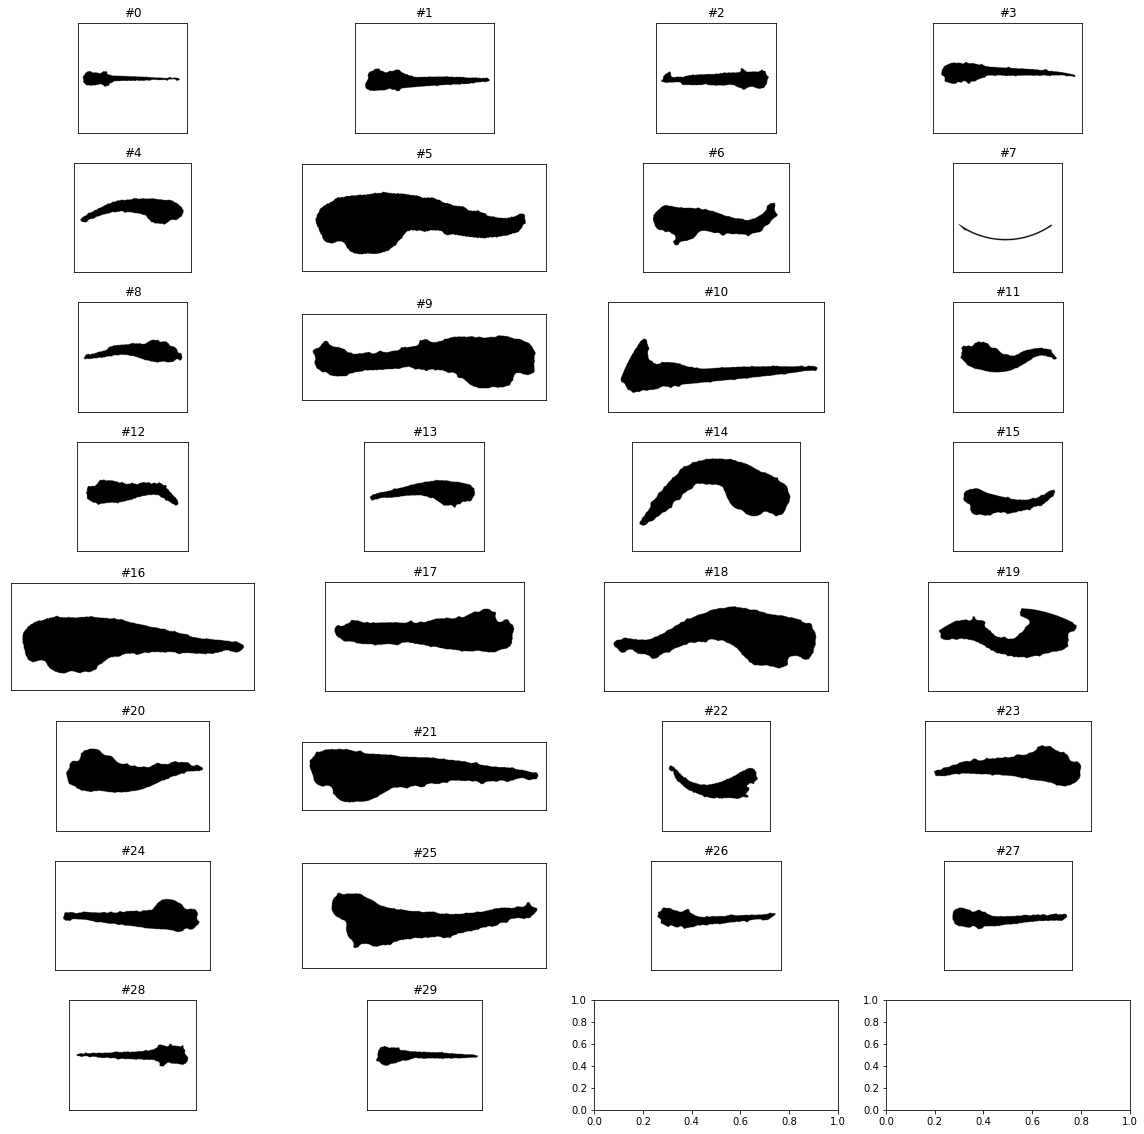

In [10]:
plot_images(rotated, nums=True)

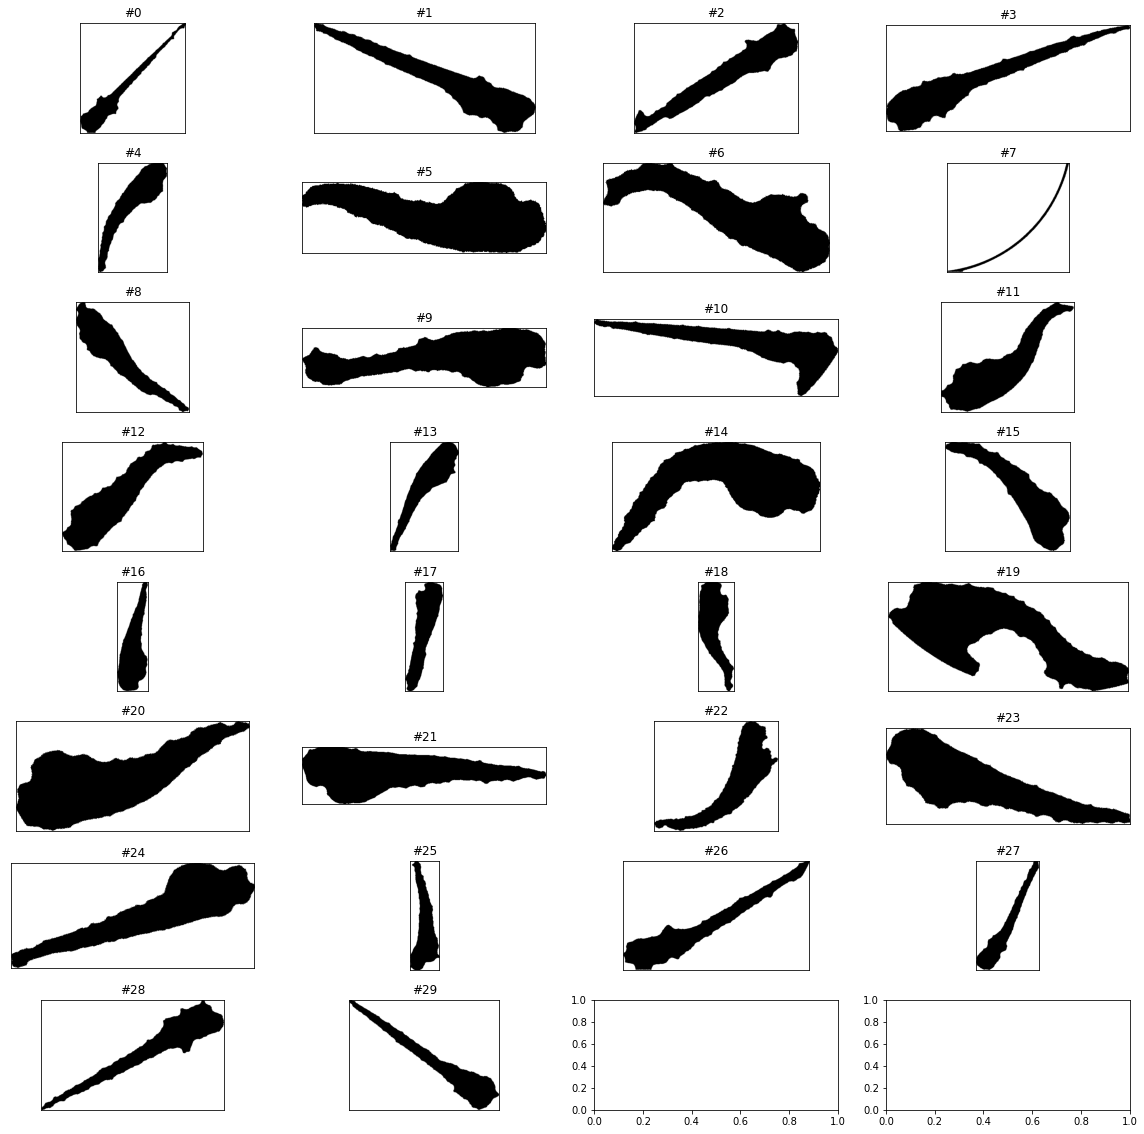

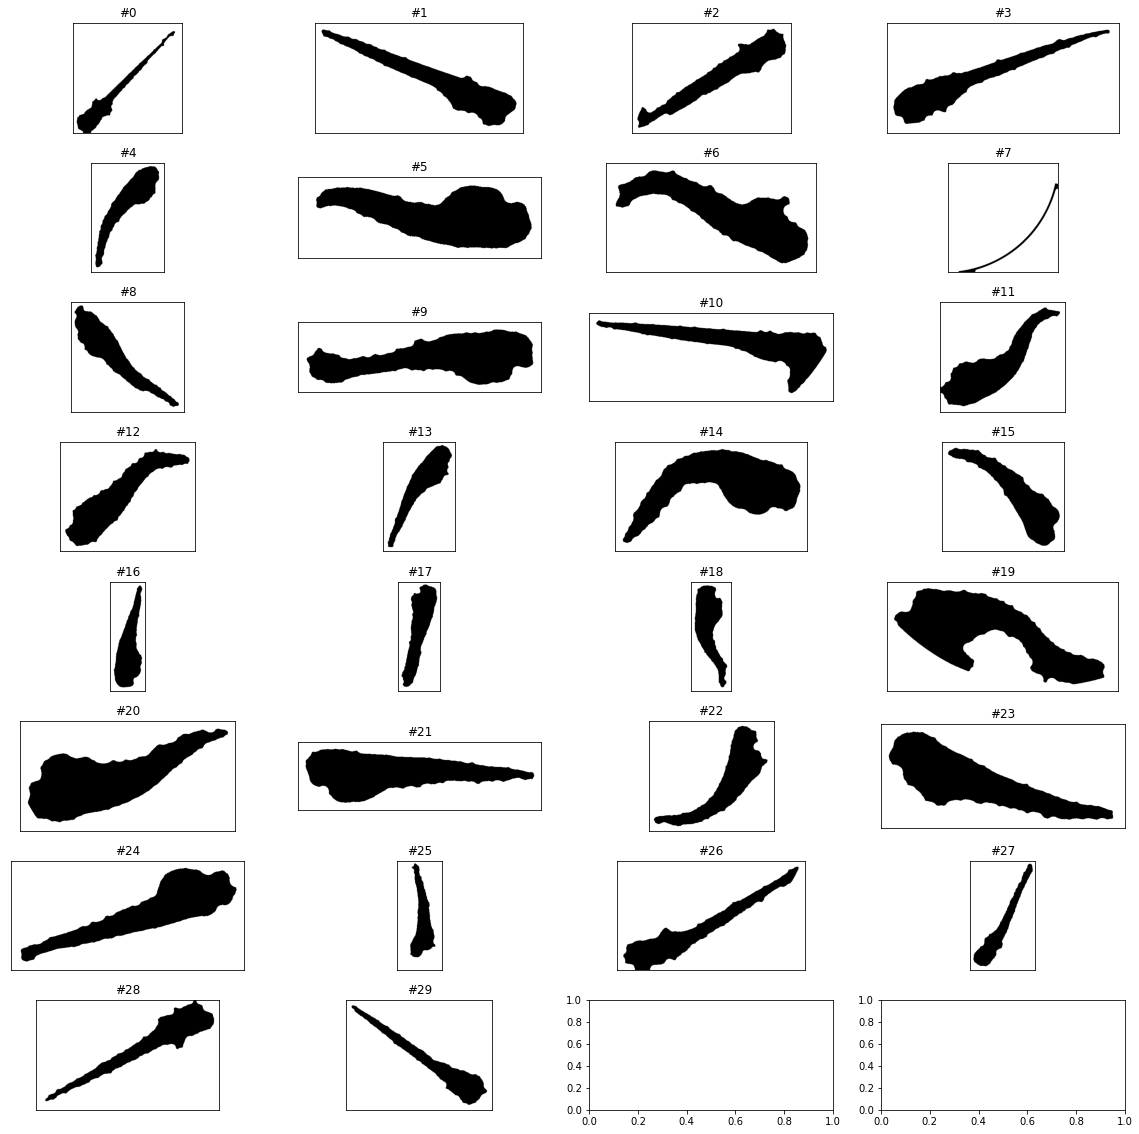

In [11]:
plot_images(rotated_, nums=True)
plot_images(maks, nums=True)

In [ ]:
from src.measure import limits_marked
import cv2
from skimage.morphology import skeletonize

re = []
re_ = []
for i, r in enumerate(rotated):
    re.append(limits_marked(r))
    re_.append(np.logical_xor((skeletonize(r, method='lee')), (rotated[i])))
plot_images(re, nums=True)
plot_images(re_)

In [ ]:
def joints(skeleton):
    xx, yy = skeleton.nonzero()
    n = len(xx)

    dist_mat = ((xx[:, None] - xx[None, :]) ** 2 + (yy[:, None] - yy[None, :]) ** 2)
    adj_mat = (dist_mat <= 2).astype(int)
    # joints will have more than 2 neighbors and endpoints
    # will have only one.
    ends = np.where(adj_mat.sum(1) == 1)[0]
    intersections = np.where(adj_mat.sum(1) > 2)[0]
    return intersections




In [ ]:
def get_endpoints_of_skeleton(skeleton: np.ndarray) -> np.ndarray:
    kernel = np.asarray([
        [-1, -1, -1],
        [-1, 2, -1],
        [-1, -1, -1]
    ])
    skeleton = normalize_0_255(skeleton.astype(float)).astype(np.uint8)
    return cv2.filter2D(skeleton, -1, kernel).astype(bool)


In [ ]:
fish = re_[19]
print(fish.shape)

kernel = np.asarray([
    [-1, -1, -1],
    [-1, 2, -1],
    [-1, -1, -1]
])

fish = normalize_0_255(fish.astype(float)).astype(np.uint8)
filtered = cv2.filter2D(fish, -1, kernel).astype(bool)
plt.imshow(binary_dilation(filtered, disk(1)), 'binary')

print(filtered.nonzero())